In [1]:
from PIL import Image
from functools import partial

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import pywt

In [2]:
n = 128
Jmax = np.log2(n)-1
Jmin = (Jmax-3)

J = Jmax-Jmin + 1
u = np.hstack(([4**(-J)], 4**(-np.floor(np.arange(J + 2./3,1,-1./3)))))
U = np.transpose(np.tile(u, (n,n,1)),(2,0,1))
tau = 1.9*np.min(u)

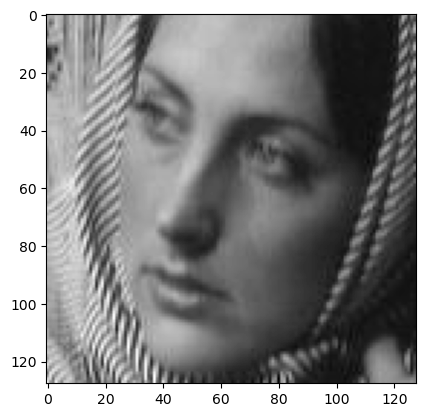

In [4]:
# Reading the image
img_pil = Image.open('barbara.jpg').convert("L")  # Convert to grayscale
img = np.array(img_pil)  # Convert PIL Image to NumPy array
img = img[60:60+n, 250:250+n]/255.  # Crop the image to n x n
plt.imshow(img, cmap='gray')
plt.show()

In [5]:
def generate_problem(img, *, p, snr):
    p = 0.3 # Percentage of pixels to clip
    mask = np.random.binomial(1, 1-p, size=img.shape)  # Generate a random mask
    img_clipped = img * mask  # Clip the image
    img_clipped = np.clip(img_clipped + generate_noise(img, snr), 0, 1) # Add noise to the clipped image
    return img_clipped, mask

def generate_noise(img, snr):
    N= img.shape[0]*img.shape[1]
    noise_var = (np.sum(img**2)/N)* np.exp(-snr / 10)
    noise = np.random.normal(0, np.sqrt(noise_var), img.shape)
    return noise

def add_noise(img, snr):
    return img + generate_noise(img, snr)

def soft_thresholding(x, T):
    return x*np.maximum(1-T/np.maximum(abs(x), 1e-10*np.ones(np.shape(x))), np.zeros(np.shape(x)))

def hard_thresholding(x, T):
    return x*(np.abs(x) > T)

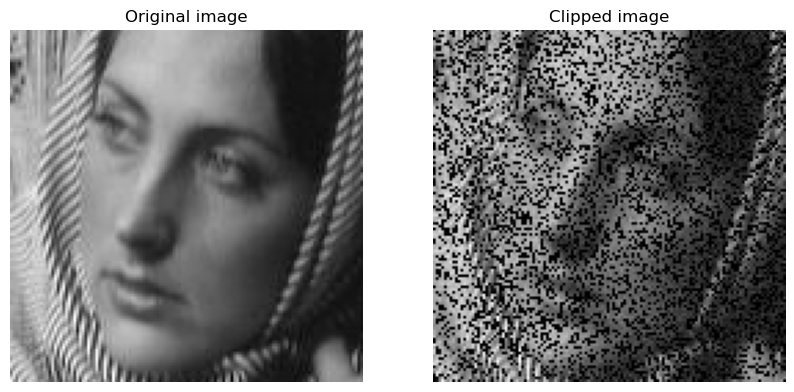

In [6]:
np.random.seed(10)

img_clipped, mask = generate_problem(img, p=0.2, snr=50)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(img, cmap='gray')
ax1.set_title('Original image')
ax1.axis('off')

ax2.imshow(img_clipped, cmap='gray')
ax2.set_title('Clipped image')
ax2.axis('off')

plt.show()

In [13]:
from wavelet_transform import perform_wavelet_transf

def Xi(a, **kwargs):
    return perform_wavelet_transf(a, Jmin=Jmin, dir=-1, **kwargs)

def PsiS(f, **kwargs):
    return perform_wavelet_transf(f, Jmin=Jmin, dir=+1, **kwargs)

def Psi(a, **kwargs):
    return Xi(a/U, **kwargs)

def clip_img(x):
    return x * mask

def proj_c(image):
    return (1-mask)*image + mask*img_clipped

In [18]:
def soft_solution(img_clipped, *, niter, lamb_start, lamb_end, **wavelet_kwargs):
    lambda_list = np.linspace(lamb_start, lamb_end, niter)
    a = U*PsiS(img_clipped, **wavelet_kwargs)
    for i in tqdm(range(niter)):
        img_1 = Psi(a, **wavelet_kwargs)
        d = img_clipped-clip_img(img_1)
        a = soft_thresholding(a + tau*PsiS(clip_img(d), **wavelet_kwargs) , lambda_list[i]*tau) 
    return Psi(a, **wavelet_kwargs)

In [15]:
def hard_solution(img_clipped, *, niter, lambda_start, lambda_end, **wavelet_kwargs):
    lambda_list = np.linspace(lambda_start, lambda_end, niter)
    fixed_image = img_clipped.copy()
    for i in tqdm(range(niter)):
        fixed_image = Xi(hard_thresholding(PsiS(proj_c(fixed_image), **wavelet_kwargs), lambda_list[i]), **wavelet_kwargs)

    return fixed_image

In [19]:
img_1 = soft_solution(img_clipped, niter=1000, lamb_start=0.03, lamb_end=0, ti=1, filter='linear')

100%|██████████| 1000/1000 [00:11<00:00, 88.13it/s]


In [23]:

img_2 = hard_solution(img_clipped, niter=500, lambda_start=1, lambda_end=0, ti=1)

100%|██████████| 500/500 [00:07<00:00, 71.37it/s]


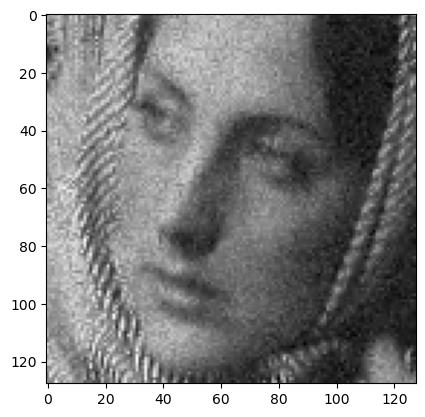

In [20]:
plt.imshow(img_1, cmap='gray')

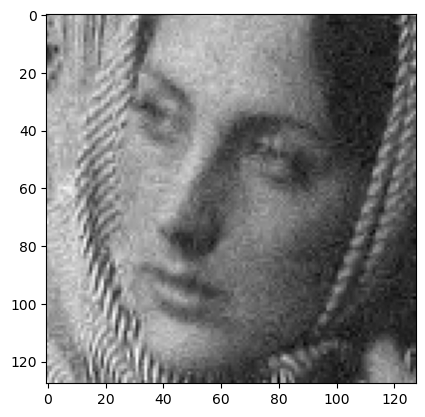

In [24]:
plt.imshow(img_2, cmap='gray')

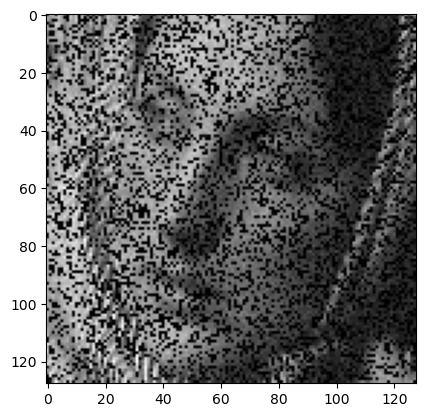

In [271]:
plt.imshow(img_clipped, cmap='gray')